In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls gdrive/MyDrive/images_IOSTAR 
path_img ='gdrive/MyDrive/images_IOSTAR'

GT_01.png  GT_21.png  GT_37.png       star03_OSN.jpg  star28_ODN.jpg
GT_02.png  GT_26.png  GT_48.png       star08_OSN.jpg  star32_ODC.jpg
GT_03.png  GT_28.png  star01_OSC.jpg  star21_OSC.jpg  star37_ODN.jpg
GT_08.png  GT_32.png  star02_OSC.jpg  star26_ODC.jpg  star48_OSN.jpg


Accuracy = 0.9695568835268914 , Recall = 0.9255193197718222


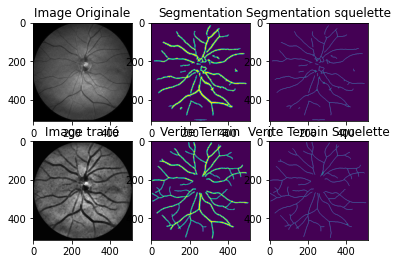

In [512]:
import numpy as np
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image
from skimage.morphology import square, diamond, octagon, rectangle, star, disk
from skimage.morphology import remove_small_objects, thin
from skimage.filters.rank import entropy, enhance_contrast_percentile, otsu
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte
import math
from skimage import data, filters
from matplotlib import pyplot as plt
import skimage.color as color
import cv2

#Ouvrir l'image originale en niveau de gris
img =  np.asarray(Image.open(path_img+'/star48_OSN.jpg')).astype(np.uint8)
img_original = img

#Égaliser l'histogramme d'une image en niveaux de gris.
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img = clahe.apply(img)

#Erosion de l'image
img = erosion(img,selem=disk(2))
img = erosion(img,selem=rectangle(1,3))
img = erosion(img,selem=rectangle(3,1))

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]
#On ne considere que les pixels dans le disque inscrit 
img_mask = (np.ones(img.shape)).astype(np.bool_)
#Ici on moins 1500 à droite de l'inégalité pour ne pas avoir des pixels autour du cercle.
invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > (nrows / 2)**2-1500)
img_mask[invalid_pixels] = 0

def my_segmentation(img, img_mask):
  # ici il faut ecrire votre code
  # Un seuil pour avoir une segmentation initiale
  seuil = filters.threshold_sauvola(img,window_size=31,k=0.14,r=50)
  img_out = (img_mask & (img < seuil))
  # Revenir au epaisseur original
  img_out = erosion(img_out, disk(2)).astype(np.bool_)
  # Eliminer la partie centrale des vaisseaux
  img_out2 = erosion(img_out, disk(5)).astype(np.bool_)
  img_out = img_out^img_out2
  # Supprimer de petits objets (bruits) 
  img_out = remove_small_objects(img_out, min_size=72)

  return img_out

def evaluate(img_out, img_GT):
  # Code d'evaluation
  GT_skel  = skeletonize(img_GT)
  img_out_skel  = skeletonize(img_out)
  TP = np.sum(img_GT & img_out) # Vrais positifs
  FP = np.sum(img_out_skel & ~img_GT) # Faux positifs (relaxes)
  FN = np.sum(GT_skel & ~img_out) # Faux negatifs (relaxes)

  ACCU = TP / (TP + FP) # Precision
  RECALL = TP / (TP + FN) # Rappel
  return ACCU, RECALL, img_out_skel, GT_skel

img_out = my_segmentation(img,img_mask).astype(np.bool_)

#Ouvrir l'image Verite Terrain en booleen
img_GT =  np.asarray(Image.open(path_img+'/GT_48.png')).astype(np.bool_)

ACCU, RECALL, img_out_skel, GT_skel = evaluate(img_out, img_GT)
print('Accuracy =', ACCU,', Recall =', RECALL)



plt.subplot(231)
plt.imshow(img_original,cmap = 'gray')
plt.title('Image Originale')
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
plt.subplot(234)
plt.imshow(img,cmap = 'gray')
plt.title('Image traité')
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

